<a href="https://colab.research.google.com/github/julycapstone2020/Pneumonia-Detection-Challenge/blob/development/ssd_colab_training_CF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/SSD_Keras_GITHUB')

In [ ]:
%tensorflow_version 1.x

In [ ]:
# Install 2.1.0 for saving model
!pip install q keras==2.0.4

In [ ]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

#from keras_ssd300 import ssd_300
from keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from AnchorBox.keras_layer_AnchorBoxes import AnchorBoxes
from AnchorBox.keras_layer_DecodeDetections import DecodeDetections
from AnchorBox.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from AnchorBox.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

ModuleNotFoundError: ignored

**1. Set the model configuration parameters**
This section sets the configuration parameters for the model definition. The parameters set here are being used both by the ssd_300() function that builds the SSD300 model as well as further down by the constructor for the SSDInputEncoder object that is needed to run the training. Most of these parameters are needed to define the anchor boxes.

The parameters as set below produce the original SSD300 architecture that was trained on the Pascal VOC datsets, i.e. they are all chosen to correspond exactly to their respective counterparts in the .prototxt file that defines the original Caffe implementation. Note that the anchor box scaling factors of the original SSD implementation vary depending on the datasets on which the models were trained. The scaling factors used for the MS COCO datasets are smaller than the scaling factors used for the Pascal VOC datasets. The reason why the list of scaling factors has 7 elements while there are only 6 predictor layers is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. Refer to the documentation for details.

As mentioned above, the parameters set below are not only needed to build the model, but are also passed to the SSDInputEncoder constructor further down, which is responsible for matching and encoding ground truth boxes and anchor boxes during the training. In order to do that, it needs to know the anchor box parameters.

In [ ]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 2 # Number of positive classes
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
model_mode = 'training'

In [ ]:
Cur_Directory = '/content/drive/My Drive/SSD_Keras_GITHUB'

In [ ]:
WeightFile = os.path.join(Cur_Directory,"VGG_ILSVRC_16_layers_fc_reduced.h5")

In [ ]:
# 1: Build the Keras model.

#K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = os.path.join(Cur_Directory,"VGG_ILSVRC_16_layers_fc_reduced.h5")

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)




Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead







Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [ ]:
model.save(os.path.join(Cur_Directory,"model_ssd_initial_1.h5"))

In [ ]:
model_path = os.path.join(Cur_Directory,"model_ssd_initial_1.h5")

In [ ]:
model_trained = os.path.join(Cur_Directory,"ssd300_pneumonia_epoch-39_loss-4.3320_val_loss-4.2565.h5")

**2.2 Load a previously created model**
If you have previously created and saved a model and would now like to load it, execute the next code cell. The only thing you need to do here is to set the path to the saved model HDF5 file that you would like to load.

The SSD model contains custom objects: Neither the loss function nor the anchor box or L2-normalization layer types are contained in the Keras core library, so we need to provide them to the model loader.

This next code cell assumes that you want to load a model that was created in 'training' mode. If you want to load a model that was created in 'inference' or 'inference_fast' mode, you'll have to add the DecodeDetections or DecodeDetectionsFast layer type to the custom_objects dictionary below.

If there is an error "arg5 must be an error or tuple" Please follow as per "https://github.com/soaxelbrooke/keras/commit/aaada44607e8f45a13732347f70a2b372ac729b2"

In [ ]:
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

#K.clear_session() # Clear previous models from memory.

model = load_model(model_trained, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

In [ ]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300, 300, 3)   0                                            
____________________________________________________________________________________________________
identity_layer (Lambda)          (None, 300, 300, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
input_mean_normalization (Lambda (None, 300, 300, 3)   0           identity_layer[0][0]             
____________________________________________________________________________________________________
input_channel_swap (Lambda)      (None, 300, 300, 3)   0           input_mean_normalization[0][0]   
___________________________________________________________________________________________

In [ ]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.


train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
Data_Directory = "/content/drive/My Drive/SSD_Keras_GITHUB/Data"
train_images_dir      = os.path.join(Data_Directory,"TrainImages_Original")
val_images_dir      = os.path.join(Data_Directory,"ValidImages_Original")
#VOC_2012_images_dir      = '../../datasets/VOCdevkit/VOC2012/JPEGImages/'
csv_path_train  = os.path.join(Data_Directory,"FinalTrain.csv")
csv_path_valid  = os.path.join(Data_Directory,"FinalValid.csv")

# The directories that contain the annotations.
# VOC_2007_annotations_dir      = '../../datasets/VOCdevkit/VOC2007/Annotations/'
# VOC_2012_annotations_dir      = '../../datasets/VOCdevkit/VOC2012/Annotations/'


# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background','No Pneumonia','Pneumonia']

train_dataset.parse_csv(train_images_dir,labels_filename=csv_path_train,input_format=['image_name','xmin','ymin','xmax','ymax','class_id'],include_classes='all',random_sample=False,ret=False,verbose=True)

val_dataset.parse_csv(val_images_dir,labels_filename=csv_path_valid,input_format=['image_name','xmin','ymin','xmax','ymax','class_id'],include_classes='all',random_sample=False,ret=False,verbose=True)


# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.




#train_dataset.create_hdf5_dataset(file_path=train_hd5_path,resize=False,variable_image_size=True,verbose=True)

#val_dataset.create_hdf5_dataset(file_path=valid_hd5_path,resize=False,variable_image_size=True,verbose=True)                         

In [ ]:
# 3: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size)) #7584
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  7584
Number of images in the validation dataset:	  2400


In [ ]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [ ]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.

model_checkpoint = ModelCheckpoint(filepath='ssd300_pneumonia_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 
csv_logger = CSVLogger(filename='ssd300_pneumonia_training_log.csv',
                       separator=',',
                       append=True)



learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule)

#terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler
             ]
             

In [ ]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 40
steps_per_epoch = 75
'''

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              verbose=1)
                              
'''

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch,
                              verbose=1)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Epoch 1/40
75/75 [==============================] - 1471s - loss: 12.8491 - val_loss: 6.7077
Epoch 2/40
75/75 [==============================] - 1389s - loss: 6.5668 - val_loss: 6.2019
Epoch 3/40
75/75 [==============================] - 1402s - loss: 6.2218 - val_loss: 5.8323
Epoch 4/40
75/75 [==============================] - 546s - loss: 6.0242 - val_loss: 5.8093
Epoch 5/40
75/75 [==============================] - 387s - loss: 5.8924 - val_loss: 5.6804
Epoch 6/40
75/75 [==============================] - 394s - loss: 5.8369 - val_loss: 5.7299
Epoch 7/40
75/75 [==============================] - 389s - loss: 5.7018 - val_loss: 5.5491
Epoch 8/40
75/75 [==============================] - 394s - loss: 5.6992 - val_loss: 5.4122
Epoch 9/40
75/75 [==============================] - 389s - loss: 5.5693 - val_loss: 5.3163
Epoch 10/40
75/75 [==============================] - 389s

In [ ]:
pwd

'/content/drive/My Drive/SSD_Keras_GITHUB'

In [ ]:
!ls

AnchorBox
BoundingBox
bounding_box_utils.ipynb
Data
data_generator
keras_layer_AnchorBoxes.ipynb
keras_layer_DecodeDetectionsFast.ipynb
keras_layer_DecodeDetections.ipynb
keras_layer_L2Normalization.ipynb
keras_loss_function
keras_ssd300.py
model_ssd_initial_1.h5
New_Train_List.txt
__pycache__
ssd300_pneumonia_epoch-00_loss-87.6879_val_loss-41.6286.h5
ssd300_pneumonia_epoch-01_loss-72.9878_val_loss-13.6403.h5
ssd300_pneumonia_training_log.csv
ssd300_training.ipynb
ssd_encoder_decoder
VGG_ILSVRC_16_layers_fc_reduced.h5


In [ ]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=500,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=True)

In [ ]:
# 2: Generate samples.
# batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator) 

# use the abve code if the output of generate is yielding

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = predict_generator

In [ ]:
i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: /content/drive/My Drive/SSD_Keras_GITHUB/Data/ValidImages_Original/fb92d9dc-51e7-4311-8e68-ccc610fc175a.jpg

Ground truth boxes:

[1 0 0 0 0]


In [ ]:
y_act=[]
top_k =[]
for i in range(0,len(batch_images)):
  boxes = np.array(batch_original_labels[i])
  top_k.append(len(batch_original_labels[i]))

  if len(boxes)<2:
    for box in boxes:
      y_act.append(box[0])
  else:
    boxes = boxes[0]
    value = boxes[0]
    y_act.append(value)

In [ ]:
len(y_act)

500

In [ ]:
y_pred = model.predict(batch_images)

In [ ]:
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.26,
                                   iou_threshold=0.35,
                                   top_k=2,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

In [ ]:
len(y_pred_decoded)

500

In [ ]:
# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  2.     0.27 545.   168.   866.   948.  ]]


In [ ]:
len(y_pred_decoded_inv)

500

In [ ]:
y_pred=[]
for i in range(0,len(y_pred_decoded_inv)):
  try:
    value = int(boxes[i][0][0])
  except:
    value=1
  y_pred.append(value)

In [ ]:
print(len(y_act))
print(len(y_pred))

500
500


In [ ]:
from sklearn.metrics import confusion_matrix, zero_one_loss, classification_report, accuracy_score
print(classification_report(y_act, y_pred, labels=np.unique(y_pred)))

              precision    recall  f1-score   support

           1       0.84      0.27      0.41       258
           2       0.55      0.95      0.69       242

    accuracy                           0.60       500
   macro avg       0.69      0.61      0.55       500
weighted avg       0.70      0.60      0.55       500



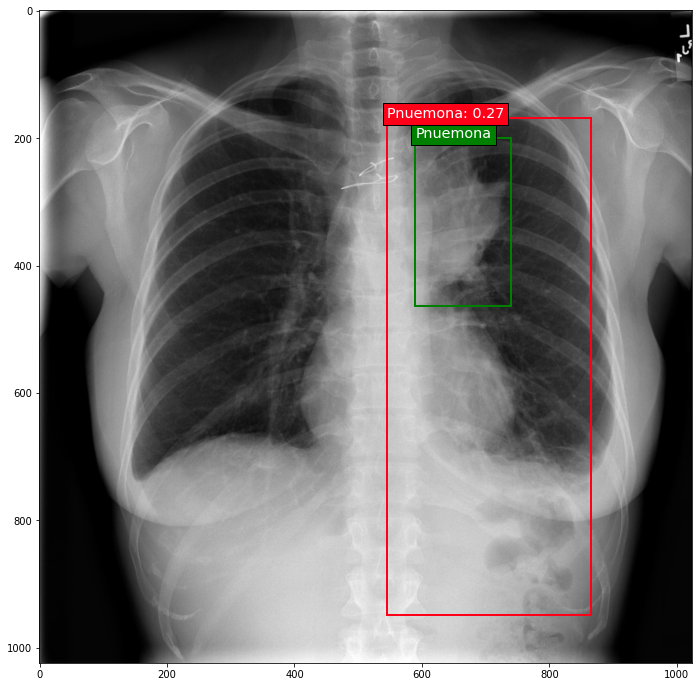

In [ ]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'No Pnuemonia','Pnuemona']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
print(n_classes)

2


In [ ]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=val_dataset,
                      model_mode=model_mode)



In [ ]:
results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=32,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

Number of images in the evaluation dataset: 2400

Producing predictions batch-wise: 100%|██████████| 75/75 [17:03<00:00, 13.65s/it]
No predictions for class 1/2
Matching predictions to ground truth, class 2/2.: 100%|██████████| 480000/480000 [00:22<00:00, 21366.53it/s]
Computing precisions and recalls, class 1/2
Computing precisions and recalls, class 2/2


IndexError: ignored

In [ ]:
mean_average_precision, average_precisions, precisions, recalls = results

In [ ]:
mean_average_precision, average_precisions, precisions, recalls = results

FileNotFoundError: ignored